# Exploratory Statistics on Variant Attributes

This comes from the example notebook and the [tour of scikit-allel](http://alimanfoo.github.io/2016/06/10/scikit-allel-tour.html) blog post.

The first stage of any analysis is mostly to look at distributions and make sure they aren't too weird looking.

In [5]:
import numpy as np
import zarr
import pandas as pd
import dask.array as da
import allel
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')
%matplotlib inline

distributed.scheduler - INFO - Register tcp://10.35.35.2:38435
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.35.2:38435
distributed.core - INFO - Starting established connection


## Cluster Setup

In [2]:
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=30)
cluster

distributed.scheduler - INFO - Clear task state
/opt/conda/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
distributed.scheduler - INFO -   Scheduler at:   tcp://10.35.63.92:39333
distributed.scheduler - INFO -   dashboard at:                    :41583


In [4]:
from dask.distributed import Client
client = Client(cluster)
#client

distributed.scheduler - INFO - Receive client connection: Client-cee28f98-c992-11ea-80e3-66032811ec33
distributed.core - INFO - Starting established connection


## Get the Data

In [8]:
import gcsfs

gcs_bucket_fs = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='anon', access='read_only')

storage_path = 'ag1000g-release/phase2.AR1/variation/main/zarr/pass/ag1000g.phase2.ar1.pass'
store = gcsfs.mapping.GCSMap(storage_path, gcs=gcs_bucket_fs, check=False, create=False)
callset = zarr.Group(store)

distributed.scheduler - INFO - Remove worker tcp://10.35.14.2:41219
distributed.core - INFO - Removing comms to tcp://10.35.14.2:41219


In [13]:
chrom = '3R'

In [14]:
# Get the passed variants from the vcf file
loc_pass_variants = callset[chrom]['variants/FILTER_PASS'][:]
loc_pass_variants

array([ True,  True,  True, ...,  True,  True,  True])

In [15]:
# Get it in a table
variants = allel.VariantChunkedTable(callset[chrom]['variants'], 
                                     names=['POS', 'REF', 'ALT', 'DP', 'MQ', 'QD'],
                                     index='POS')
variants

<VariantChunkedTable shape=(14481509,) dtype=[('POS', '<i4'), ('REF', 'S1'), ('ALT', 'S1', (3,)), ('DP', '<i4'), ('MQ', '<f4'), ('QD', '<f4')]
   nbytes=276.2M cbytes=-6 cratio=-48271696.7
   values=zarr.hierarchy.Group>

In [16]:
pos = variants['POS'][:]
pos

array([    9526,     9531,     9536, ..., 53195269, 53195273, 53195279],
      dtype=int32)

# Stats Time

## Visualize variant density

As a first step into getting to know these data, let’s make a plot of variant density, which will simply show us how many SNPs there are and how they are distributed along the chromosome.

The data on SNP positions and various other attributes of the SNPs are stored in the Zarr file. Each of these can be treated as a column in a table, so let’s set up a table with some of the columns we’ll need for this and subsequent analyses.

In [23]:
def plot_windowed_variant_density(pos, window_size, title=None):
    """plot of variant density
    which will simply show us how many SNPs there are and how they are distributed along the chromosome
    """
    
    # setup windows 
    bins = np.arange(0, pos.max(), window_size)
    
    # use window midpoints as x coordinate
    x = (bins[1:] + bins[:-1])/2
    
    # compute variant density in each window
    h, _ = np.histogram(pos, bins=bins)
    y = h / window_size
    
    # plot
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.despine(ax=ax, offset=10)
    ax.plot(x, y)
    ax.set_xlabel('Chromosome position (bp)')
    ax.set_ylabel('Variant density (bp$^{-1}$)')
    if title:
        ax.set_title(title)

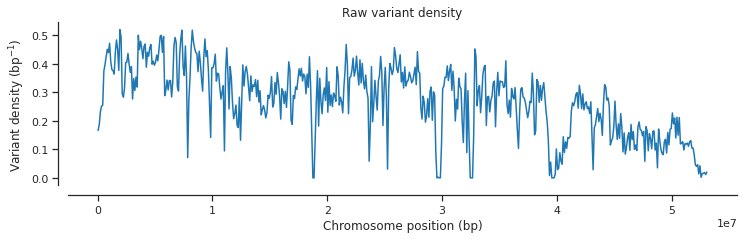

In [18]:
plot_windowed_variant_density(pos, window_size=100000, title='Raw variant density')

## Explore variant attributes

As I mentioned above, each SNP also has a number “annotations”, which are data attributes that originally came from the “INFO” field in the VCF file. These are important for data quality, so let’s begin by getting to know a bit more about the numerical range and distribution of some of these attributes.

Each attribute can be loaded from the table we setup earlier into a numpy array. E.g., load the “DP” field into an array.

In [22]:
dp = variants['DP'][:]
dp

array([34663, 34876, 34697, ..., 38673, 38460, 39154], dtype=int32)

In [24]:
def plot_variant_hist(f, bins=30):
    """plot a frequency distribution for any variant attribute."""
    x = variants[f][:]
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.despine(ax=ax, offset=10)
    ax.hist(x, bins=bins)
    ax.set_xlabel(f)
    ax.set_ylabel('No. variants')
    ax.set_title('Variant %s distribution' % f)

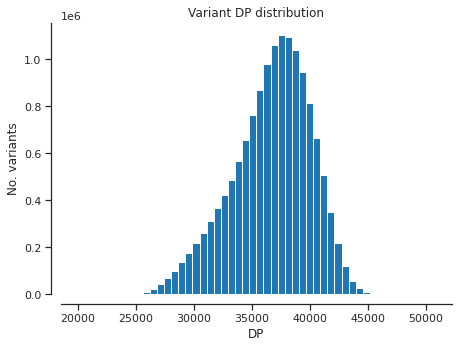

In [25]:
# “DP” is total depth of coverage across all samples.

plot_variant_hist('DP', bins=50)

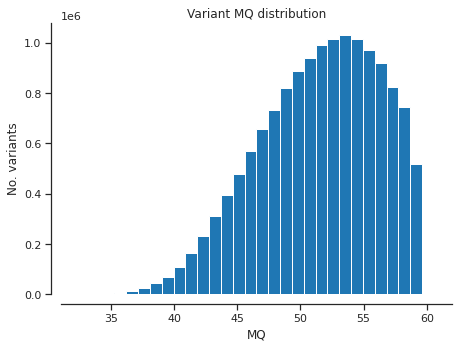

In [26]:
# “MQ” is average mapping quality across all samples.

plot_variant_hist('MQ')

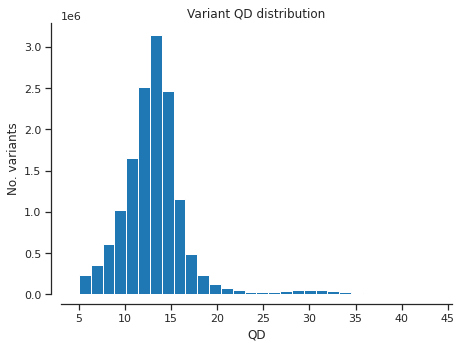

In [27]:
# “QD” is a slightly odd statistic but turns out to be very useful for finding poor quality SNPs. 
# Roughly speaking, high numbers mean that evidence for variation is strong (concentrated), 
# low numbers mean that evidence is weak (dilute).

plot_variant_hist('QD')

We can also look at the joint frequency distribution of two attributes.

In [33]:
def plot_variant_hist_2d(f1, f2, downsample):
    x = variants[f1][:][::downsample]
    y = variants[f2][:][::downsample]
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.despine(ax=ax, offset=10)
    ax.hexbin(x, y, gridsize=40)
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_title('Variant %s versus %s joint distribution' % (f1, f2))

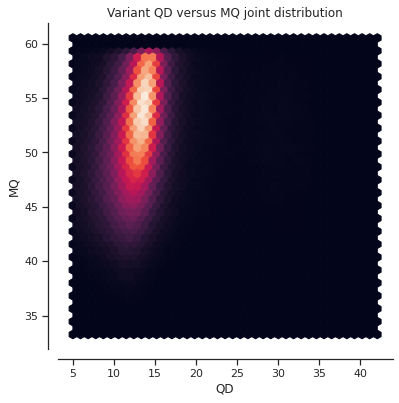

distributed.scheduler - INFO - Remove worker tcp://10.35.16.2:35871
distributed.core - INFO - Removing comms to tcp://10.35.16.2:35871
distributed.scheduler - INFO - Remove worker tcp://10.35.29.2:36215
distributed.core - INFO - Removing comms to tcp://10.35.29.2:36215


In [34]:
plot_variant_hist_2d('QD', 'MQ', downsample=10)